In [31]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import sys

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
%matplotlib inline

In [42]:
import tensorflow_datasets as tfds

In [32]:
BATCH_SIZE = 32
IMG_INP_SIZE = 192
EPOCHS = 10

In [ ]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'coco/2017',
    data_dir='G:\data',
    as_supervised=True,
    with_info=True,    
#     split=['train[:90%]', 'train[90%:]'],
)

In [33]:
from pycocotools.coco import COCO

In [34]:
COCO_ROOT = 'G:\data\coco'

### Universal Dataset Class for Segmentation

In [35]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для сегментационного датасета COCO

In [36]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [37]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=15.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [38]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=EPOCHS, inp_size=IMG_INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=IMG_INP_SIZE)

### Построение модели

In [39]:
def build_model():
    x = tf.keras.layers.Input((IMG_INP_SIZE, IMG_INP_SIZE, 3))
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out1)
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out2)
    
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out3)
    
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out4)
    
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(out)
    
    return tf.keras.Model(inputs=x, outputs=out)

In [40]:
try:
    del model
    K.clear_session()
except:
    pass
model = build_model()

tf.keras.utils.plot_model(model)

In [53]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer="adam", loss=loss)

In [54]:
checkpoint = ModelCheckpoint('dz_04_semanticheskaya_segmentatsiya.hdf5',
                            monitor="val_loss",
                            save_best_only=True,
                            period=1,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_loss", 
                                        min_delta=1e-6, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [55]:
%%time
history = model.fit(train_ds, 
                 epochs=EPOCHS,
                 steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE, 
                 validation_data=val_ds, 
                 validation_steps=10,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train for 2003 steps, validate for 10 steps
Epoch 1/10
2002/2003 [============================>.] - ETA: 0s - loss: 0.4339
Epoch 00001: val_loss improved from inf to 0.41788, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
2003/2003 [==============================] - 1349s 673ms/step - loss: 0.4339 - val_loss: 0.4179
Epoch 2/10
2002/2003 [============================>.] - ETA: 0s - loss: 0.3553
Epoch 00002: val_loss improved from 0.41788 to 0.37450, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
2003/2003 [==============================] - 1366s 682ms/step - loss: 0.3553 - val_loss: 0.3745
Epoch 3/10
2002/2003 [============================>.] - ETA: 0s - loss: 0.3173
Epoch 00003: val_loss improved from 0.37450 to 0.32223, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
2003/2003 [==============================] - 1582s 790ms/step - loss: 0.3173 - val_loss: 0.3222
Epoch 4/10
2002/2003 [============================>.] - ETA: 0s - loss: 0.2931
Epoch 00004: val_

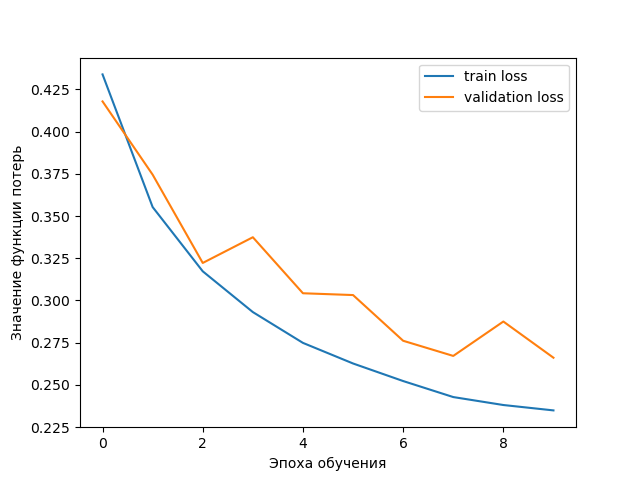

In [78]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.show()

In [57]:
model.save('my_model.h5')

In [58]:
model.save_weights('./checkpoints/my_checkpoint')

In [2]:
model = tf.keras.models.load_model('my_model.h5')

### Предсказание модели

In [10]:
test_batch = next(iter(val_ds))
prediction = model.predict(test_batch)

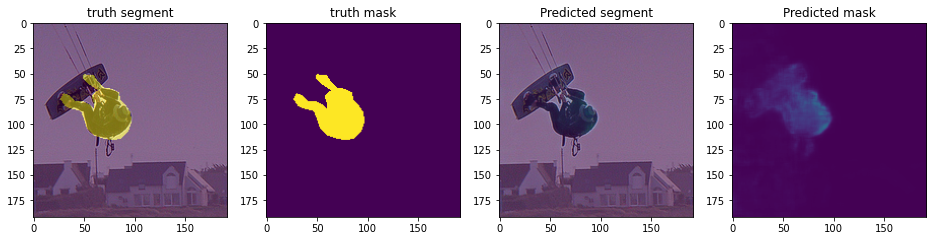

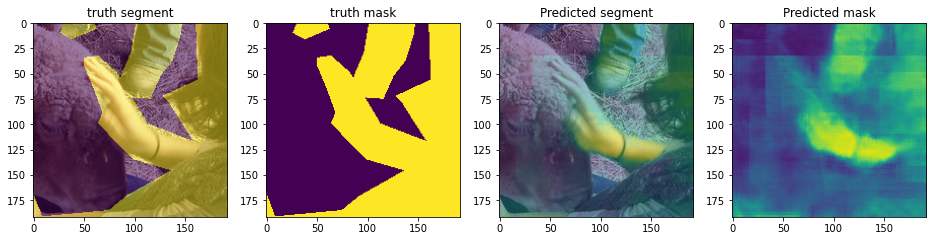

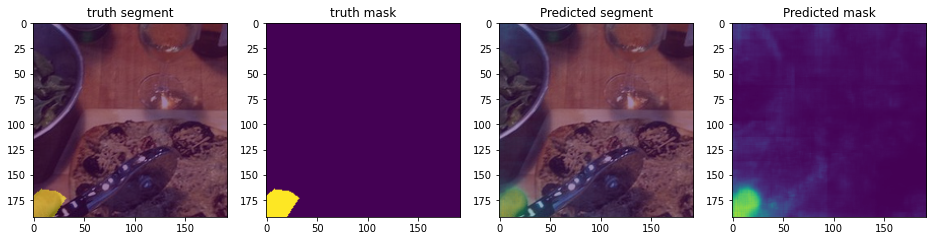

In [26]:
for idx in range(3):
    sample = test_batch[0][idx].numpy()
    
    fig = plt.figure(figsize=(16,6))
    
    plt.subplot(1,4,1)
    plt.title("truth segment")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,2)
    plt.title("truth mask")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    plt.subplot(1,4,3)
    plt.title("Predicted segment")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,4)
    plt.title("Predicted mask")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    
    plt.show()

#### Неплохо былобы использовать 100 эпох но каждая эпоха занимает по 20 минут